# D87-1
* **請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響**
* **請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果**

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

/home/rex/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""
建立實驗的比較組合
"""
reduce_lr_factor = [0.2,0.5,0.8]
redice_lr_patient = [3,5,10]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

W0807 20:10:45.597466 140593330484992 deprecation_wrapper.py:119] From /home/rex/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0807 20:10:45.598122 140593330484992 deprecation_wrapper.py:119] From /home/rex/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0807 20:10:45.600211 140593330484992 deprecation_wrapper.py:119] From /home/rex/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



Numbers of exp: 0, reduce_factor: 0.20, reduce_patient: 3


W0807 20:10:45.801811 140593330484992 deprecation_wrapper.py:119] From /home/rex/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0807 20:10:45.969332 140593330484992 deprecation_wrapper.py:119] From /home/rex/anaconda3/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0807 20:10:45.978919 140593330484992 deprecation_wrapper.py:119] From /home/rex/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0807 20:10:46.076418 140593330484992 deprecation.py:323] From /home/rex/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

50000/50000 [==============================] - 3s 69us/step - loss: 1.5369 - acc: 0.4639 - val_loss: 1.6565 - val_acc: 0.4234
Epoch 14/25
50000/50000 [==============================] - 4s 72us/step - loss: 1.5211 - acc: 0.4702 - val_loss: 1.6429 - val_acc: 0.4271
Epoch 15/25
50000/50000 [==============================] - 3s 66us/step - loss: 1.5044 - acc: 0.4757 - val_loss: 1.6330 - val_acc: 0.4309
Epoch 16/25
50000/50000 [==============================] - 4s 71us/step - loss: 1.4898 - acc: 0.4815 - val_loss: 1.6255 - val_acc: 0.4369
Epoch 17/25
50000/50000 [==============================] - 4s 70us/step - loss: 1.4757 - acc: 0.4841 - val_loss: 1.6182 - val_acc: 0.4360
Epoch 18/25
50000/50000 [==============================] - 3s 70us/step - loss: 1.4619 - acc: 0.4906 - val_loss: 1.6088 - val_acc: 0.4395
Epoch 19/25
50000/50000 [==============================] - 4s 73us/step - loss: 1.4496 - acc: 0.4950 - val_loss: 1.6020 - val_acc: 0.4431
Epoch 20/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 5s 98us/step - loss: 2.5881 - acc: 0.1853 - val_loss: 2.4143 - val_acc: 0.2478
Epoch 2/25
50000/50000 [==============================] - 4s 74us/step - loss: 2.0862 - acc: 0.2955 - val_loss: 2.1175 - val_acc: 0.3025
Epoch 3/25
50000/50000 [==============================] - 4s 70us/step - loss: 1.9190 - acc: 0.3413 - val_loss: 1.9820 - val_acc: 0.3310
Epoch 4/25
50000/50000 [==============================] - 3s 69us/step - loss: 1.8280 - acc: 0.3663 - val_loss: 1.9069 - val_acc: 0.3476
Epoch 5/25
50000/50000 [==============================] - 3s 68us/step - loss: 1.7663 - acc: 0.3879 - val_loss: 1.8445 - val_acc: 0.3631
Epoch 6/25
50000/50000 [==============================] - 4s 73us/step - loss: 1.7205 - acc: 0.4009 - val_loss: 1.8059 - val_acc: 0.3725
Epoch 7/25
50000/50000 [==============================] - 4s 73us/step - loss: 1.6842 - acc: 0.4137 - val_loss: 1.7736 - val_acc

50000/50000 [==============================] - 4s 74us/step - loss: 1.3914 - acc: 0.5195 - val_loss: 1.5728 - val_acc: 0.4532
Epoch 25/25
50000/50000 [==============================] - 4s 70us/step - loss: 1.3806 - acc: 0.5228 - val_loss: 1.5682 - val_acc: 0.4559
Numbers of exp: 5, reduce_factor: 0.50, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_16 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalizati

Epoch 12/25
50000/50000 [==============================] - 4s 81us/step - loss: 1.5595 - acc: 0.4577 - val_loss: 1.6604 - val_acc: 0.4208
Epoch 13/25
50000/50000 [==============================] - 3s 69us/step - loss: 1.5422 - acc: 0.4640 - val_loss: 1.6480 - val_acc: 0.4264
Epoch 14/25
50000/50000 [==============================] - 3s 68us/step - loss: 1.5264 - acc: 0.4692 - val_loss: 1.6370 - val_acc: 0.4273
Epoch 15/25
50000/50000 [==============================] - 4s 70us/step - loss: 1.5101 - acc: 0.4759 - val_loss: 1.6310 - val_acc: 0.4291
Epoch 16/25
50000/50000 [==============================] - 3s 66us/step - loss: 1.4957 - acc: 0.4812 - val_loss: 1.6203 - val_acc: 0.4331
Epoch 17/25
50000/50000 [==============================] - 4s 73us/step - loss: 1.4809 - acc: 0.4868 - val_loss: 1.6129 - val_acc: 0.4351
Epoch 18/25
50000/50000 [==============================] - 3s 66us/step - loss: 1.4688 - acc: 0.4913 - val_loss: 1.6034 - val_acc: 0.4388
Epoch 19/25
50000/50000 [=========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 6s 116us/step - loss: 2.5673 - acc: 0.1856 - val_loss: 2.3993 - val_acc: 0.2319
Epoch 2/25
50000/50000 [==============================] - 4s 74us/step - loss: 2.0745 - acc: 0.2980 - val_loss: 2.1090 - val_acc: 0.2902
Epoch 3/25
50000/50000 [==============================] - 3s 66us/step - loss: 1.9140 - acc: 0.3399 - val_loss: 1.9761 - val_acc: 0.3291
Epoch 4/25
50000/50000 [==============================] - 4s 82us/step - loss: 1.8275 - acc: 0.3642 - val_loss: 1.8919 - val_acc: 0.3512
Epoch 5/25
50000/50000 [==============================] - 4s 73us/step - loss: 1.7690 - acc: 0.3850 - val_loss: 1.8416 - val_acc: 0.3664
Epoch 6/25
50000/50000 [==============================] - 3s 67us/step - loss: 1.7251 - acc: 0.3982 - val_loss: 1.8088 - val_acc: 0.3762
Epoch 7/25
50000/50000 [==============================] - 3s 70us/step - loss: 1.6886 - acc: 0.4103 - val_loss: 1.7715 - val_ac

50000/50000 [==============================] - 4s 82us/step - loss: 0.8008 - acc: 0.7393 - val_loss: 1.3413 - val_acc: 0.5361
Epoch 23/25
50000/50000 [==============================] - 4s 81us/step - loss: 0.7992 - acc: 0.7400 - val_loss: 1.3442 - val_acc: 0.5338

Epoch 00023: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
Epoch 24/25
50000/50000 [==============================] - 4s 76us/step - loss: 0.7958 - acc: 0.7417 - val_loss: 1.3442 - val_acc: 0.5343
Epoch 25/25
50000/50000 [==============================] - 4s 81us/step - loss: 0.7948 - acc: 0.7416 - val_loss: 1.3445 - val_acc: 0.5353
Numbers of exp: 10, reduce_factor: 0.20, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               

Epoch 9/25
50000/50000 [==============================] - 6s 126us/step - loss: 1.9482 - acc: 0.3329 - val_loss: 1.9970 - val_acc: 0.3270
Epoch 10/25
50000/50000 [==============================] - 6s 124us/step - loss: 1.9261 - acc: 0.3389 - val_loss: 1.9784 - val_acc: 0.3315
Epoch 11/25
50000/50000 [==============================] - 7s 140us/step - loss: 1.9072 - acc: 0.3456 - val_loss: 1.9626 - val_acc: 0.3361
Epoch 12/25
50000/50000 [==============================] - 8s 162us/step - loss: 1.8893 - acc: 0.3503 - val_loss: 1.9476 - val_acc: 0.3410
Epoch 13/25
50000/50000 [==============================] - 4s 86us/step - loss: 1.8732 - acc: 0.3559 - val_loss: 1.9347 - val_acc: 0.3444
Epoch 14/25
50000/50000 [==============================] - 4s 82us/step - loss: 1.8588 - acc: 0.3585 - val_loss: 1.9226 - val_acc: 0.3456
Epoch 15/25
50000/50000 [==============================] - 4s 81us/step - loss: 1.8449 - acc: 0.3634 - val_loss: 1.9106 - val_acc: 0.3506
Epoch 16/25
50000/50000 [======

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 7s 134us/step - loss: 2.5878 - acc: 0.1681 - val_loss: 2.4112 - val_acc: 0.2208
Epoch 2/25
50000/50000 [==============================] - 4s 77us/step - loss: 2.2521 - acc: 0.2467 - val_loss: 2.2189 - val_acc: 0.2625
Epoch 3/25
50000/50000 [==============================] - 4s 75us/step - loss: 2.1383 - acc: 0.2766 - val_loss: 2.1376 - val_acc: 0.2787
Epoch 4/25
50000/50000 [==============================] - 4s 77us/step - loss: 2.0709 - acc: 0.2935 - val_loss: 2.0847 - val_acc: 0.2948
Epoch 5/25
50000/50000 [==============================] - 4s 80us/step - loss: 2.0231 - acc: 0.3068 - val_loss: 2.0461 - val_acc: 0.3058
Epoch 6/25
50000/50000 [==============================] - 4s 81us/step - loss: 1.9858 - acc: 0.3176 - val_loss: 2.0157 - val_acc: 0.3158
Epoch 7/25
50000/50000 [==============================] - 4s 79us/step - loss: 1.9565 - acc: 0.3266 - val_loss: 1.9911 - val_ac

50000/50000 [==============================] - 4s 79us/step - loss: 1.7186 - acc: 0.4032 - val_loss: 1.8009 - val_acc: 0.3739
Epoch 25/25
50000/50000 [==============================] - 4s 83us/step - loss: 1.7114 - acc: 0.4055 - val_loss: 1.7947 - val_acc: 0.3761
Numbers of exp: 15, reduce_factor: 0.80, reduce_patient: 3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_46 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalizati

Epoch 12/25
50000/50000 [==============================] - 4s 83us/step - loss: 1.8493 - acc: 0.3585 - val_loss: 1.9053 - val_acc: 0.3467
Epoch 13/25
50000/50000 [==============================] - 4s 81us/step - loss: 1.8341 - acc: 0.3632 - val_loss: 1.8939 - val_acc: 0.3509
Epoch 14/25
50000/50000 [==============================] - 4s 86us/step - loss: 1.8205 - acc: 0.3681 - val_loss: 1.8827 - val_acc: 0.3530
Epoch 15/25
50000/50000 [==============================] - 4s 76us/step - loss: 1.8091 - acc: 0.3706 - val_loss: 1.8720 - val_acc: 0.3564
Epoch 16/25
50000/50000 [==============================] - 4s 82us/step - loss: 1.7983 - acc: 0.3742 - val_loss: 1.8626 - val_acc: 0.3591
Epoch 17/25
50000/50000 [==============================] - 4s 82us/step - loss: 1.7872 - acc: 0.3781 - val_loss: 1.8533 - val_acc: 0.3605
Epoch 18/25
50000/50000 [==============================] - 4s 84us/step - loss: 1.7753 - acc: 0.3824 - val_loss: 1.8448 - val_acc: 0.3638
Epoch 19/25
50000/50000 [=========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 7s 137us/step - loss: 1.8028 - acc: 0.3742 - val_loss: 2.5313 - val_acc: 0.2644
Epoch 2/25
50000/50000 [==============================] - 4s 75us/step - loss: 1.5276 - acc: 0.4587 - val_loss: 2.5440 - val_acc: 0.2663
Epoch 3/25
50000/50000 [==============================] - 3s 70us/step - loss: 1.4131 - acc: 0.5003 - val_loss: 2.7102 - val_acc: 0.2662
Epoch 4/25
50000/50000 [==============================] - 4s 86us/step - loss: 1.3419 - acc: 0.5245 - val_loss: 3.6208 - val_acc: 0.2130

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 5/25
50000/50000 [==============================] - 4s 74us/step - loss: 1.1942 - acc: 0.5831 - val_loss: 1.6667 - val_acc: 0.4094
Epoch 6/25
50000/50000 [==============================] - 4s 74us/step - loss: 1.1457 - acc: 0.6007 - val_loss: 1.5320 - val_acc: 0.4534
Epoch 7/25
50000/50000 [=====================

Epoch 22/25
50000/50000 [==============================] - 4s 71us/step - loss: 1.9054 - acc: 0.3420 - val_loss: 1.9507 - val_acc: 0.3360
Epoch 23/25
50000/50000 [==============================] - 4s 77us/step - loss: 1.8923 - acc: 0.3455 - val_loss: 1.9385 - val_acc: 0.3399
Epoch 24/25
50000/50000 [==============================] - 3s 69us/step - loss: 1.8798 - acc: 0.3488 - val_loss: 1.9274 - val_acc: 0.3429
Epoch 25/25
50000/50000 [==============================] - 4s 85us/step - loss: 1.8676 - acc: 0.3532 - val_loss: 1.9172 - val_acc: 0.3466
Numbers of exp: 20, reduce_factor: 0.20, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
__________________________________________________________

50000/50000 [==============================] - 4s 78us/step - loss: 2.1744 - acc: 0.2680 - val_loss: 2.1858 - val_acc: 0.2747
Epoch 10/25
50000/50000 [==============================] - 4s 79us/step - loss: 2.1406 - acc: 0.2777 - val_loss: 2.1558 - val_acc: 0.2792
Epoch 11/25
50000/50000 [==============================] - 5s 93us/step - loss: 2.1085 - acc: 0.2865 - val_loss: 2.1283 - val_acc: 0.2878
Epoch 12/25
50000/50000 [==============================] - 4s 88us/step - loss: 2.0806 - acc: 0.2925 - val_loss: 2.1060 - val_acc: 0.2924
Epoch 13/25
50000/50000 [==============================] - 4s 72us/step - loss: 2.0551 - acc: 0.3013 - val_loss: 2.0841 - val_acc: 0.2999
Epoch 14/25
50000/50000 [==============================] - 4s 77us/step - loss: 2.0315 - acc: 0.3069 - val_loss: 2.0647 - val_acc: 0.3049
Epoch 15/25
50000/50000 [==============================] - 4s 72us/step - loss: 2.0101 - acc: 0.3131 - val_loss: 2.0458 - val_acc: 0.3090
Epoch 16/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 16s 318us/step - loss: 2.8897 - acc: 0.1185 - val_loss: 2.8190 - val_acc: 0.1437
Epoch 2/25
50000/50000 [==============================] - 7s 139us/step - loss: 2.7256 - acc: 0.1455 - val_loss: 2.7022 - val_acc: 0.1648
Epoch 3/25
50000/50000 [==============================] - 7s 137us/step - loss: 2.6010 - acc: 0.1688 - val_loss: 2.6030 - val_acc: 0.1852
Epoch 4/25
50000/50000 [==============================] - 7s 136us/step - loss: 2.5027 - acc: 0.1901 - val_loss: 2.5181 - val_acc: 0.1984
Epoch 5/25
50000/50000 [==============================] - 7s 133us/step - loss: 2.4243 - acc: 0.2060 - val_loss: 2.4481 - val_acc: 0.2087
Epoch 6/25
50000/50000 [==============================] - 7s 133us/step - loss: 2.3605 - acc: 0.2201 - val_loss: 2.3893 - val_acc: 0.2207
Epoch 7/25
50000/50000 [==============================] - 7s 137us/step - loss: 2.3065 - acc: 0.2333 - val_loss: 2.3390 -

Epoch 24/25
50000/50000 [==============================] - 8s 165us/step - loss: 1.8782 - acc: 0.3531 - val_loss: 1.9470 - val_acc: 0.3382
Epoch 25/25
50000/50000 [==============================] - 7s 131us/step - loss: 1.8661 - acc: 0.3567 - val_loss: 1.9367 - val_acc: 0.3404
Numbers of exp: 25, reduce_factor: 0.80, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_76 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
bat

50000/50000 [==============================] - 6s 127us/step - loss: 2.1348 - acc: 0.2874 - val_loss: 2.1659 - val_acc: 0.2800
Epoch 12/25
50000/50000 [==============================] - 7s 130us/step - loss: 2.1033 - acc: 0.2957 - val_loss: 2.1374 - val_acc: 0.2887
Epoch 13/25
50000/50000 [==============================] - 5s 102us/step - loss: 2.0749 - acc: 0.3027 - val_loss: 2.1100 - val_acc: 0.2929
Epoch 14/25
50000/50000 [==============================] - 3s 70us/step - loss: 2.0496 - acc: 0.3092 - val_loss: 2.0869 - val_acc: 0.2981
Epoch 15/25
50000/50000 [==============================] - 4s 81us/step - loss: 2.0279 - acc: 0.3143 - val_loss: 2.0663 - val_acc: 0.3036
Epoch 16/25
50000/50000 [==============================] - 4s 71us/step - loss: 2.0062 - acc: 0.3215 - val_loss: 2.0465 - val_acc: 0.3079
Epoch 17/25
50000/50000 [==============================] - 4s 80us/step - loss: 1.9865 - acc: 0.3265 - val_loss: 2.0289 - val_acc: 0.3157
Epoch 18/25
50000/50000 [==================

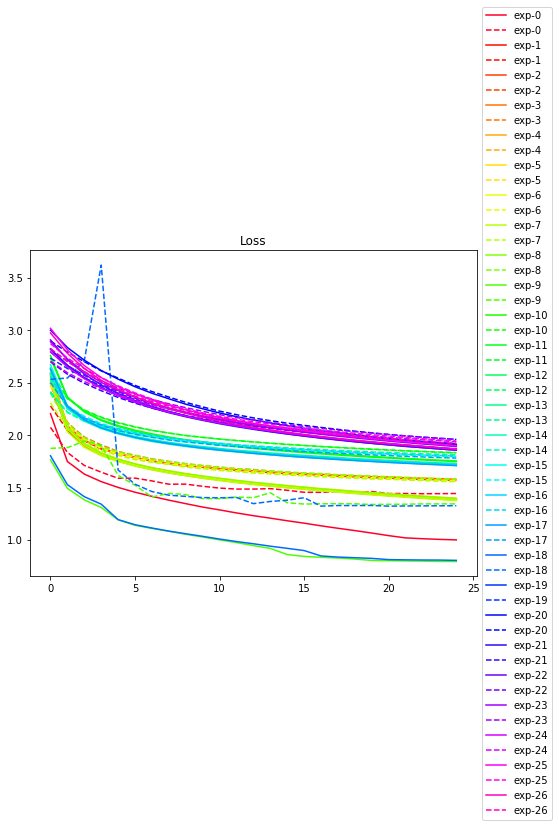

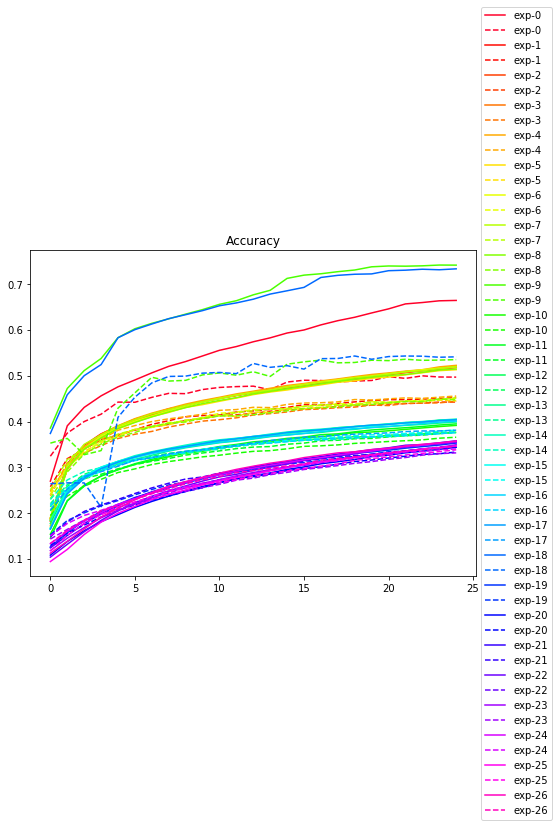

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()